In [14]:
import  pandas as pd
import numpy as np
import scaleogram as scg
import matplotlib.pyplot as plt
import pywt
from scipy import signal


In [2]:
from savgol import savitzky_golay

In [3]:
def Phase( t, p):
    phase = []    
    phase = (t/(p))- np.fix(t/(p))
    return (phase)


def T_0_fixer(T0,t,p, phase):
    phase0 = (T0/(p))- np.fix(T0/(p))
    phase = phase - phase0 - (0.25)
    for i in np.arange(len(phase)):
        if phase[i]<0:
            phase[i]=phase[i]+1
        if phase[i]>1:
            phase[i]=phase[i]-1
    return (phase)


def JDfixer(t):
    if t[0]>10000:
        t = t - 2450000
    return (t)

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [7]:
df_kelt = pd.read_excel('lc/KELT-11b.xlsx')

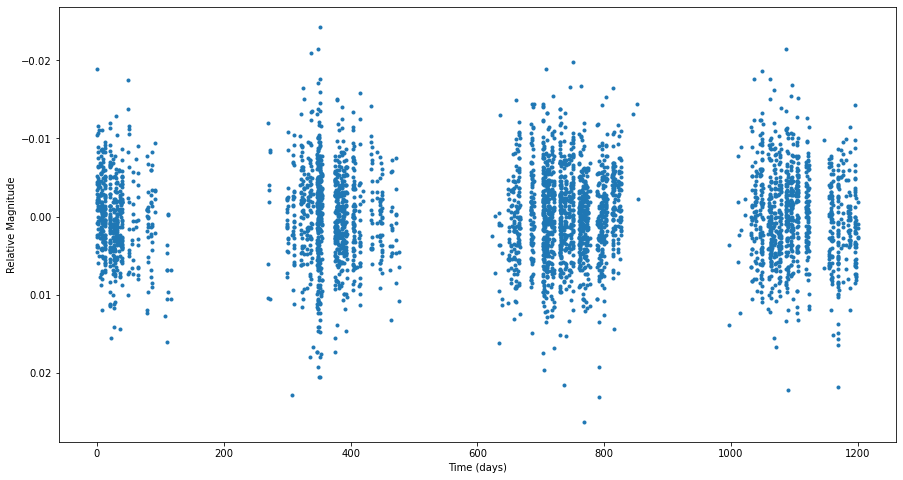

In [8]:
plt.figure(figsize = (15,8))
plt.plot(df_kelt.t-min(df_kelt.t), df_kelt.m,'.')
plt.xlabel('Time (days)')
plt.ylabel('Relative Magnitude')
plt.gca().invert_yaxis()

In [43]:
df_kelt[df_kelt.t-min(df_kelt.t) <800]

,index,t,m,e
0,1,2.455268e+06,-0.0189,0.0022
1,2,2.455268e+06,-0.0052,0.0022
2,3,2.455268e+06,-0.0104,0.0022
3,4,2.455268e+06,-0.0044,0.0023
4,5,2.455268e+06,0.0024,0.0021
...,...,...,...,...
2799,2800,2.456068e+06,0.0026,0.0021
2800,2801,2.456068e+06,-0.0030,0.0021
2801,2802,2.456068e+06,-0.0014,0.0019
2802,2803,2.456068e+06,-0.0008,0.0019


In [9]:
# Phase-folding the light curve to see the transit

p = 4.736529
t0 = 0
t_kelt = JDfixer(df_kelt.t)
phase = Phase(t_kelt, p)
phase = T_0_fixer(t0, t_kelt, p, phase)

# Phased Light Curve

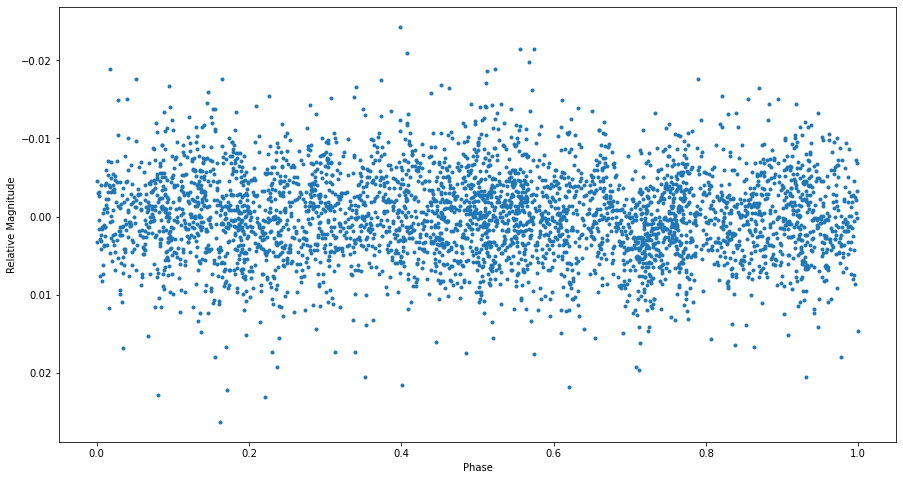

In [10]:
plt.figure(figsize = (15,8))
plt.plot(phase, df_kelt.m, '.')
plt.xlabel('Phase')
plt.ylabel('Relative Magnitude')
plt.gca().invert_yaxis()

# Using Scaleogram

In [47]:
# data = smooth(df.m, 10).squeeze()

# savitzky_golay is a smoothing filter and reduces the noise in the dataset
data = savitzky_golay(df_kelt[1500:2800].m.values,11,4).squeeze()
# data = df_kelt.m.values.squeeze()
time = df_kelt[1500:2800].t.values

N = data.size; print("Nb of samples of data:", N)

Nb of samples of data: 1300


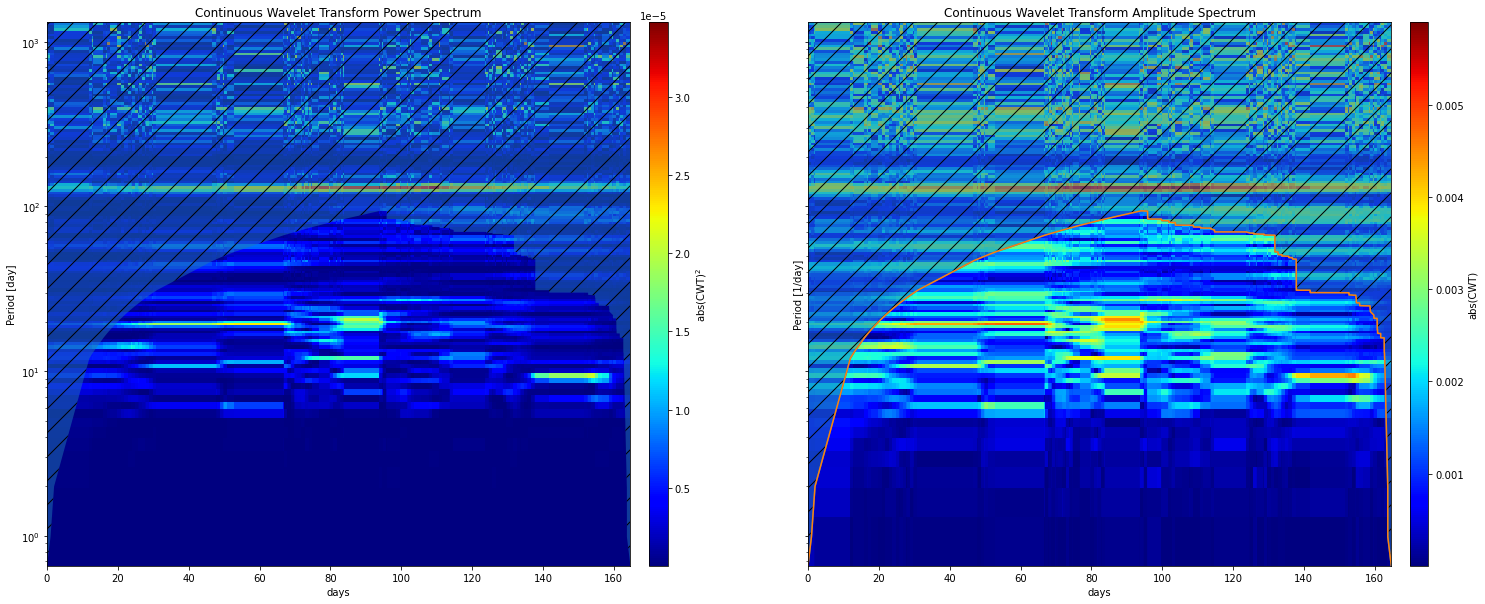

In [48]:
scales = np.logspace(0.01, 3.3, num=200, dtype=np.int32)
# scales=np.arange(20,270,1)
wavelet='cmor19-1.5'

fig, axs = plt.subplots(1,2, figsize=(25,10), sharey=True)
ax = scg.cws(time-min(time), data, wavelet=wavelet, yaxis='period', scales= scales,spectrum='power',\
             ylabel="Period [day]", xlabel='days', yscale='log', ax=axs[0])
ax1 = scg.cws(time-min(time), data, wavelet=wavelet, yaxis='period',scales= scales,\
              ylabel="Period [1/day]",xlabel='days', yscale='log', ax=axs[1])
# ax.set_ylim(0.1,0.5)
axs[0].invert_yaxis()

# Using CWT from Scipy.signal

0.023617999628186222


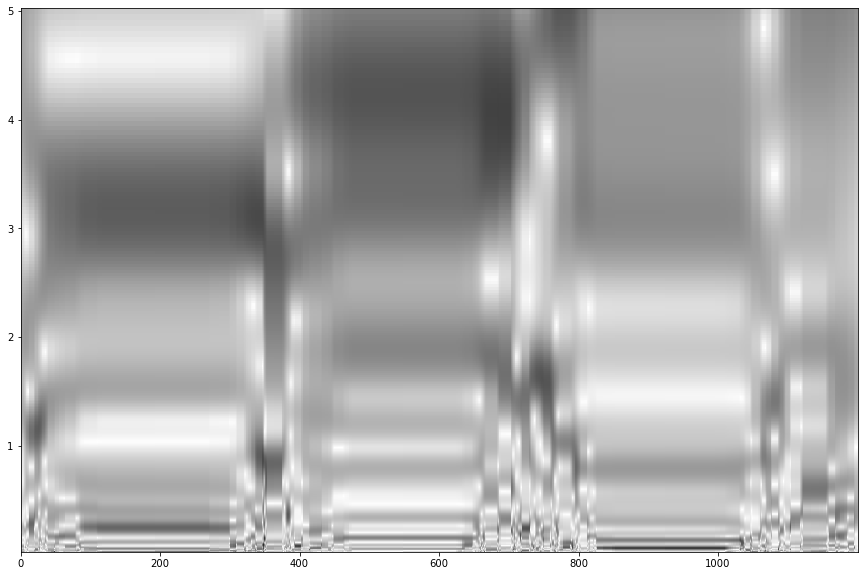

In [19]:
plt.figure(figsize=(15,10))

t = df_kelt.t.values - df_kelt.t.values[0]
dt = np.median(np.diff(df_kelt.t.values))

nyquist = 0.5 * (1./dt)


minimum_period = 1/nyquist
print(minimum_period)
maximum_period = 5#t[-1]
period = np.geomspace(minimum_period, maximum_period, 512)

w = 6

widths = w * nyquist * period / np.pi
cwtm = signal.cwt(df_kelt.m.values- np.median(df_kelt.m.values), signal.morlet2, widths, w=w)
power = np.abs(cwtm) #np.abs(cwtm)**2 / widths[:, np.newaxis]


cc = plt.pcolormesh(t, period, power, shading='auto', 
                cmap='binary')